<a href="https://colab.research.google.com/github/infomon/understanding_cnn/blob/master/notebooks/Positivity_Explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tests Positivity of visualizing methods

This notebook shows histograms being computed by carious methods on the MNIST dataset. We will first train a simple 5-layer CNN and then apply different visualizing methods. In the end we allow for a quantitative assesment by generating histograms. If positivity holds, there should be no negative relevance.

For testing the positivity axiom, we visualize relevances for an single example, where we select the last layer's neuron with the smallest value.


## Imports

In [1]:
!pip install -q git+https://github.com/albermax/innvestigate
!git clone https://github.com/infomon/understanding_cnn
import shutil
import os
if not os.path.isfile("utils.py"):
  shutil.move("/content/understanding_cnn/utils/utils.py", "/content")
if not os.path.isfile("utils_mnist.py"):
  shutil.move("/content/understanding_cnn/utils/utils_mnist.py", "/content")
if not os.path.isfile("cnn_MNIST_model.hdf5"):
  shutil.move("/content/understanding_cnn/models/pretrained_models/cnn_MNIST_model.hdf5", "/content")
!rm -r understanding_cnn

Cloning into 'understanding_cnn'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 241 (delta 8), reused 0 (delta 0), pack-reused 221
Receiving objects: 100% (241/241), 28.48 MiB | 29.98 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [0]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [3]:
%matplotlib inline  

import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

import innvestigate
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "utils.py")
mnistutils = imp.load_source("utils_mnist", "utils_mnist.py")

Using TensorFlow backend.


## Data
Load the dataset and keep some images from the test set for the analysis.

In [4]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = mnistutils.fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

x_train, y_train, x_test, y_test = data
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step


## Model
The next part trains and evaluates a CNN. Or if model is available, then use the pretrained model

In [5]:
if not os.path.isfile("cnn_MNIST_model.hdf5"):
  batch_size = 128
  epochs = 15
  input_shape = (28, 28, 1)

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu',
                   input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='exponential'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer='adam',
                metrics=['accuracy'])

  mcp_save = ModelCheckpoint('cnn_MNIST_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

  model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            callbacks=[mcp_save],
            validation_data=(x_test, y_test))

else:
  model = load_model('cnn_MNIST_model.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


## Analysis

In [0]:
# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255

noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


# Configure analysis methods and properties
# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE
    
    # Show input
    ("input",                 {},                       input_postprocessing,      "Input"),

    # Function
    ("gradient", {"postprocess": "abs"}, mnistutils.graymap, "Gradient"),  # 0
    ("smoothgrad", {"noise_scale": noise_scale,
                    "postprocess": "square"}, mnistutils.graymap, "SmoothGrad"),  # 1

    # Signal
    ("deconvnet", {}, mnistutils.bk_proj, "Deconvnet"),  # 2
    ("guided_backprop", {}, mnistutils.bk_proj, "Guided Backprop",),  # 3
    ("pattern.net", {"pattern_type": "relu"}, mnistutils.bk_proj, "PatternNet"),  # 4

    # Interaction
    ("pattern.attribution", {"pattern_type": "relu"}, mnistutils.heatmap, "PatternAttribution"),  # 5
    ("deep_taylor.bounded", {"low": input_range[0],
                                 "high": input_range[1]}, mnistutils.heatmap, "DeepTaylor"),  # 6
    ("input_t_gradient", {}, mnistutils.heatmap, "Input * Gradient"),  # 7
    ("integrated_gradients", {"reference_inputs": ri}, mnistutils.heatmap, "Integrated Gradients"),  # 8
    #("lrp.z", {}, mnistutils.heatmap, "LRP-Z"),  # 9
    ("lrp.epsilon", {"epsilon": 1}, mnistutils.heatmap, "LRP-Epsilon"),  # 10
    ("lrp.epsilon_IB", {"epsilon": 1}, mnistutils.heatmap, "LRP-Epsilon IB"),  # 11
    ("lrp.alpha_1_beta_0", {}, mnistutils.heatmap, "LRP-Alpha1-Beta0"),  # 12
    ("lrp.alpha_1_beta_0_IB", {}, mnistutils.heatmap, "LRP-Alpha1-Beta0 IB"),  # 13
        ("lrp.sequential_preset_a_flat",{"epsilon": 1},     mnistutils.heatmap,       "LRP-PresetAFlat"), #14
      ("lrp.sequential_preset_b_flat",{"epsilon": 1},     mnistutils.heatmap,       "LRP-PresetBFlat"), #15
    ]

In [8]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            neuron_selection_mode="index",
                                            **method[1])      # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(data[0], batch_size=256, verbose=1)
    analyzers.append(analyzer)

Epoch 1/1
235/235 [==============================] - 14s 59ms/step - loss: 4.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000 - broadcast_3_loss: 1.0000 - broadcast_4_loss: 1.0000
Epoch 1/1
235/235 [==============================] - 11s 46ms/step - loss: 4.0000 - broadcast_5_loss: 1.0000 - broadcast_6_loss: 1.0000 - broadcast_7_loss: 1.0000 - broadcast_8_loss: 1.0000


In [0]:
%%capture

n = 1
test_images = list(zip(data[2][:n], data[3][:n]))

analysis = np.zeros([len(test_images), len(analyzers), 28, 28, 3])
text = []


for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    y_min = prob.argmin()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        # Analyze.
        a = analyzer.analyze(x, neuron_selection=y_min)
        
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        a = mnistutils.postprocess(a)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        #a = methods[aidx][2](a)
        # Store the analysis.
        analysis[i, aidx] = a[0]

## Visualize histograms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


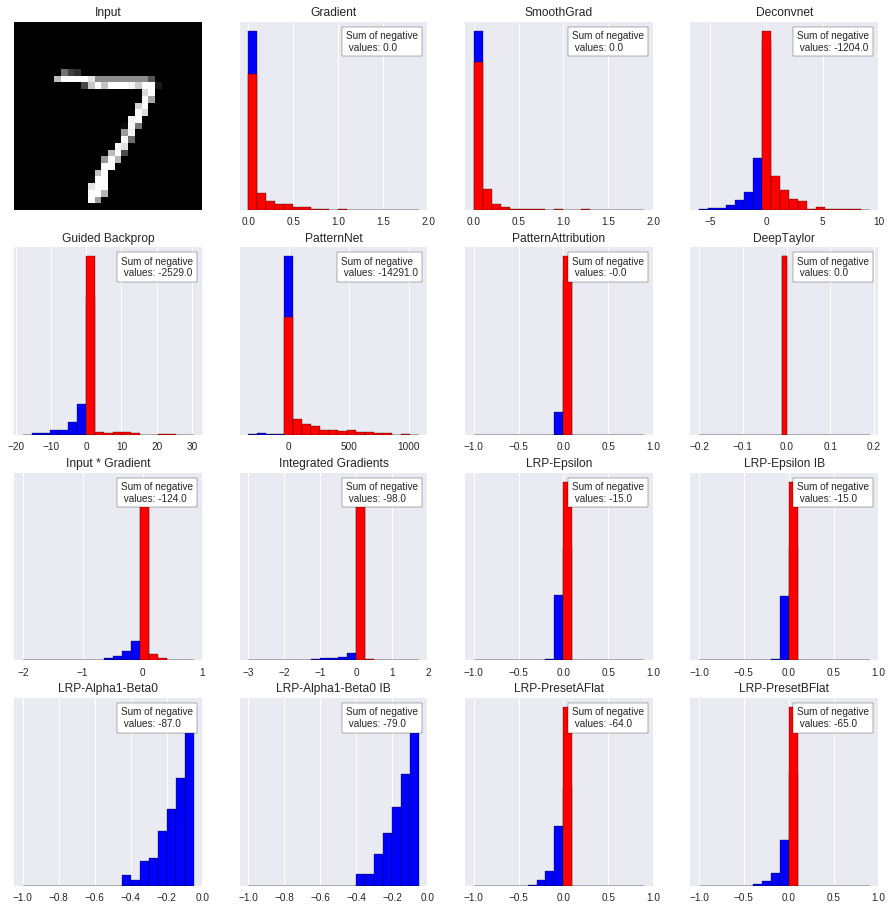

In [10]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

fig=plt.figure()
fig.subplots_adjust(0.0,0.0,2.0,3.0)
axs = []
for i,heatmap in enumerate(analysis[0]):
  if i == 0:
    ax = fig.add_subplot(4,4,1)
    ax.imshow(heatmap)
    ax.set_title(methods[i][3])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    continue
    
  axs.append(fig.add_subplot(4,4,i+1))
  x_min = np.amin(heatmap)
  x_min = np.floor(x_min)
  x_max = np.amax(heatmap)
  x_max = np.ceil(x_max)
  if x_min == x_max:
    bins = np.arange(x_min-0.2, x_max+0.2,0.01)
  else:
    bins = np.arange(x_min, x_max, (x_max-x_min)/20)
  n, bins, patches = axs[i-1].hist(np.reshape(heatmap * (heatmap < 0),(28*28*3)), bins=bins,color ='blue', edgecolor = 'black')
  n, bins, patches = axs[i-1].hist(np.reshape(heatmap * (heatmap >= 0),(28*28*3)), bins=bins,color ='red', edgecolor = 'black')
  

  #for j,patch in enumerate(patches):
  #  if bins[j] < 0:
  #    axs[i-1].set_facecolor('blue')
  axs[i-1].set_title(methods[i][3])
  axs[i-1].yaxis.set_visible(False)
  
  min_sum = np.sum(heatmap * (heatmap < 0))
  #axs[i-1].text(x=1,y=10,s='Sum of negative values: '+str(round(min_sum)),fontsize=12)
  anchored_text = AnchoredText('Sum of negative\n values: '+str(round(min_sum)), loc='upper right')
  axs[i-1].add_artist(anchored_text)
  
fig.show()